In [31]:
import torch
import numpy as np
import gym

from matplotlib import pyplot as plt 
%matplotlib inline

**Generating help regarding BlackJack**
Trying to compute all possible action labels but no success.

In [32]:
environment_name = "Blackjack-v1"
dummy_env = gym.make(environment_name)
#dummy_env.env.get_action_meanings()
help(dummy_env.unwrapped)

Help on BlackjackEnv in module gym.envs.toy_text.blackjack object:

class BlackjackEnv(gym.core.Env)
 |  BlackjackEnv(natural=False, sab=False)
 |  
 |  Simple blackjack environment
 |  
 |  Blackjack is a card game where the goal is to obtain cards that sum to as
 |  near as possible to 21 without going over.  They're playing against a fixed
 |  dealer.
 |  Face cards (Jack, Queen, King) have point value 10.
 |  Aces can either count as 11 or 1, and it's called 'usable' at 11.
 |  This game is placed with an infinite deck (or with replacement).
 |  The game starts with dealer having one face up and one face down card, while
 |  player having two face up cards. (Virtually for all Blackjack games today).
 |  
 |  The player can request additional cards (hit=1) until they decide to stop
 |  (stick=0) or exceed 21 (bust).
 |  
 |  After the player sticks, the dealer reveals their facedown card, and draws
 |  until their sum is 17 or greater.  If the dealer goes bust the player wins.
 |  


Below is the code to Generate blackjack 3-D plot for value function

In [33]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

**Evaluating State Value Function V(s)**
We will try to just evalutate state value functions and visualize those.

**Monte Carlo State Value Function**

In [34]:
environment_name = "Blackjack-v1"

from dataclasses import dataclass
from collections import defaultdict, Counter

# @dataclass
# class EpisodeStep:
#     state: Any
#     action: int
#     reward: float

"""
Since this is based on State Value Function V(s) instead of Action Value Function Q(s,a),
We cannot use it for policy iteration since it will require transition dynamics and 
we are working on model free environment.

Policy Improvement:   pi'(s) =  argmax  R(s,a) + Prob(s,a,s') * V(s')
                               a E A(s)
"""
class BlackJackAgentBasedOnStateValue:
    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = self.environment.action_space

        self.alpha = 0.03
        self.gamma = 0.8
        
        self.total_states = 32*11*2
        self.total_actions = 2
        
        self.V = defaultdict(float)
        
        #self.state_visit_counter = defaultdict(int)
        #self.rewards = defaultdict(float)

    def generate_episode(self, epsilon = 1.0):
        state = self.environment.reset()
        episode = []

        while True:
            #card_sum, dearler_card, is_ace = state
            action =  self.decide_choice(state, epsilon) 
            next_state,reward, is_done, _ = self.environment.step(action)
            episode.append( (state, action, reward) )
            if is_done:
                break
            state = next_state
        return episode

    def decide_choice(self, state, epsilon):
        # just some fixed policy evaluation
        # no policy improvement employeed
        player_sum, dealer_card, usable_ace = state
        return np.random.choice(self.total_actions,p =  [0.75, 0.25] if player_sum > 18 else [0.25, 0.75] )

    def update_state_value_function(self, episode):
        states, actions, rewards = zip(*episode)
        discount_factors = [self.gamma**i for i in range(len(states) + 1)]

        for i, state in enumerate(states):
            expected_return = np.dot(rewards[i:], discount_factors[ : -(i+1)])

            #self.rewards[state] += expected_return
            #self.state_visit_counter[state] += 1
            #self.V[state] = self.rewards[state]/self.state_visit_counter[state]

            # similar to computing average in incremental way
            # use of alpha instead of state visit counter
            # so that it works in non stationary cases(dynamic environment) as well
            old_value = self.V[state] 
            self.V[state] = old_value + self.alpha*(expected_return - old_value)

launch_environment = gym.make(environment_name)
print(launch_environment.action_space.n, launch_environment.observation_space)

agent = BlackJackAgentBasedOnStateValue(launch_environment)

epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995

for i in range(100000):
    episode = agent.generate_episode(epsilon)
    agent.update_state_value_function(episode)
    epsilon = max(epsilon* epsilon_decay, epsilon_end)
#print(agent.rewards)

2 Tuple(Discrete(32), Discrete(11), Discrete(2))


**Visualization Code for Monte Carlo State Value Function**

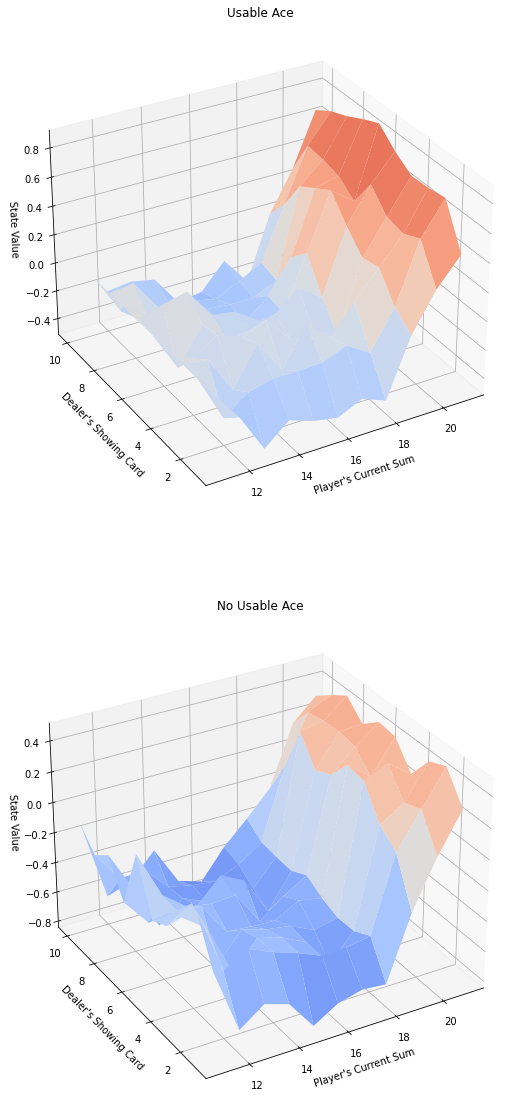

In [35]:
V = dict((state,state_value_function) for state, state_value_function in agent.V.items())
plot_blackjack_values(V)

**Monte Carlo action value function**

Using policy improvement compared to static policy resulted in higher action value function Q(s,a) in case of **no unusable ace** as well. 

2 Tuple(Discrete(32), Discrete(11), Discrete(2))


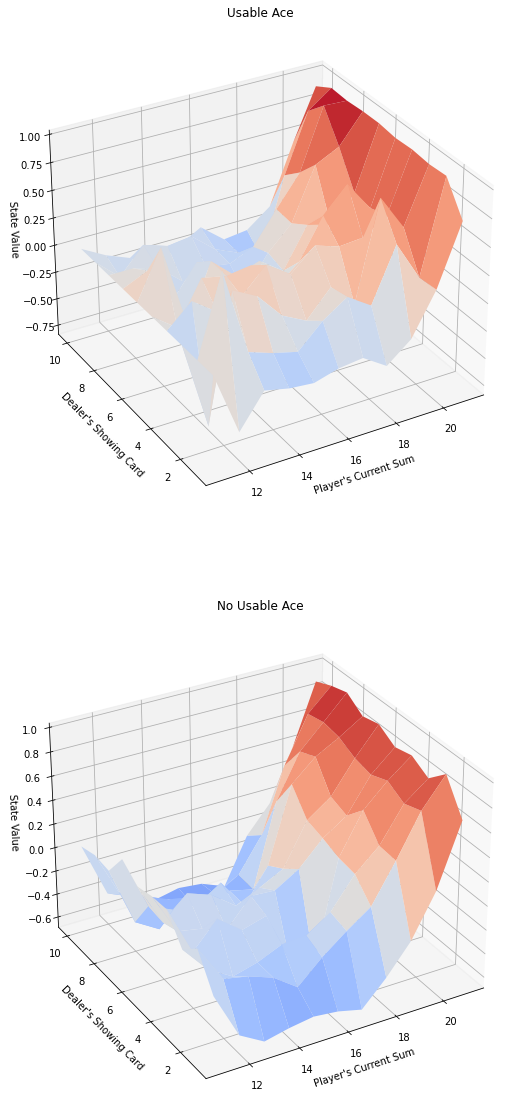

In [36]:
class BlackJackAgentBasedOnActionValue:
    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = self.environment.action_space

        self.alpha = 0.03
        self.gamma = 0.8
        
        self.total_states = 32*11*2
        self.total_actions = 2
        
        self.Q = defaultdict( lambda: np.zeros(self.total_actions) )
        
        self.state_action_visit_counter = defaultdict(lambda: np.zeros(self.total_actions))
        self.rewards = defaultdict(lambda: np.zeros(self.total_actions))

    def generate_episode(self, epsilon = 1.0):
        state = self.environment.reset()
        episode = []

        while True:
            #card_sum, dearler_card, is_ace = state
            action =  self.decide_choice(state, epsilon) 
            next_state,reward, is_done, _ = self.environment.step(action)
            episode.append( (state, action, reward) )
            if is_done:
                break
            state = next_state
        return episode

    # static policy used for policy evaluation only
    # not for policy improvement
    def decide_choice(self, state, epsilon):
        # just some fixed policy evaluation
        # no policy improvement employeed
        player_sum, dealer_card, usable_ace = state
        return np.random.choice(self.total_actions,p =  [0.75, 0.25] if player_sum > 18 else [0.25, 0.75] )

    @staticmethod
    def get_probability_for_action(Q_s, epsilon, num_of_actions):
        # 1 - epsilon + (epsilon/total_actions) for action having max action-value-function
        # epsilon / total_actions for others
        policy_state = np.ones(num_of_actions) * (epsilon / num_of_actions)
        max_action = np.argmax(Q_s)
        policy_state[max_action] = 1 - epsilon + (epsilon/num_of_actions)
        return policy_state

    # this employs policy improvement by using epsilon-greedy policy
    def decide_choice(self, state, epsilon):
        if state not in self.Q:
            return np.random.choice(self.total_actions)

        probs = self.get_probability_for_action(self.Q[state], epsilon, self.total_actions)
        return np.random.choice(np.arange(self.total_actions), p = probs)

    def update_action_value_function(self, episode):
        states, actions, rewards = zip(*episode)
        discount_factors = [self.gamma**i for i in range(len(states) + 1)]

        for i, state in enumerate(states):
            action = actions[i]
            expected_return = np.dot(rewards[i:], discount_factors[ : -(i+1)])

            self.rewards[state][action] += expected_return
            self.state_action_visit_counter[state][action] += 1
            self.Q[state][action] = self.rewards[state][action]/self.state_action_visit_counter[state][action]

            # similar to computing average in incremental way
            # use of alpha instead of state action visit counter
            # so that it works in non stationary cases(dynamic environment) as well
            # old_value = self.Q[state][action]
            # self.Q[state][action] = old_value + self.alpha*(expected_return - old_value)

launch_environment = gym.make(environment_name)
print(launch_environment.action_space.n, launch_environment.observation_space)

agent = BlackJackAgentBasedOnActionValue(launch_environment)

epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995

for i in range(20000):
    episode = agent.generate_episode(epsilon)
    agent.update_action_value_function(episode)
    epsilon = max(epsilon* epsilon_decay, epsilon_end)
#print(agent.rewards)

action_values = dict((state,np.max(actions) ) for state, actions in agent.Q.items())
plot_blackjack_values(action_values)

**Temporal Difference for State Value Function**

In [37]:
environment_name = "Blackjack-v1"

from dataclasses import dataclass
from collections import defaultdict, Counter

# @dataclass
# class EpisodeStep:
#     state: Any
#     action: int
#     reward: float
"""
Cannot use policy iteration since we are using State Value Function V(s) in model free environment 
with temporal difference
"""
class BlackJackAgentTemporalDifferenceBasedOnStateValue:
    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = self.environment.action_space

        self.alpha = 0.01
        self.gamma = 0.8
        
        self.total_states = 32*11*2
        self.total_actions = 2

        self.V = defaultdict(float)

    def update_during_episode(self, epsilon = 1.0):
        current_state = self.environment.reset()

        while True:
            #card_sum, dearler_card, is_ace = state
            action =  self.decide_choice(current_state, epsilon) 
            next_state,reward, is_done, _ = self.environment.step(action)
            self.update_value_function_during_trajectory(next_state, current_state, reward, is_done)

            if is_done:
                break
            current_state = next_state

    # static policy for to decide action for policy evaluation only.    
    def decide_choice(self, state, epsilon):
        player_sum, dealer_card, usable_ace = state
        return np.random.choice(self.total_actions,p =  [0.75,0.25] if player_sum > 18 else [0.25, 0.75] )

    def update_value_function_during_trajectory(self, current_state, next_state, current_reward, is_end_of_episode: bool):
        estimated_return = current_reward + self.gamma* self.V[next_state]
        previous_old_value = self.V[current_state]

        self.V[current_state] = previous_old_value + self.alpha*(estimated_return - previous_old_value)

launch_environment = gym.make(environment_name)
print(launch_environment.action_space.n, launch_environment.observation_space)

agent = BlackJackAgentTemporalDifferenceBasedOnStateValue(launch_environment)

epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995

for i in range(40000):
    epsilon = max(epsilon* epsilon_decay, epsilon_end)
    episode = agent.update_during_episode()
#print(agent.rewards)

2 Tuple(Discrete(32), Discrete(11), Discrete(2))


**Visualization Temporal Difference for State Value Function**

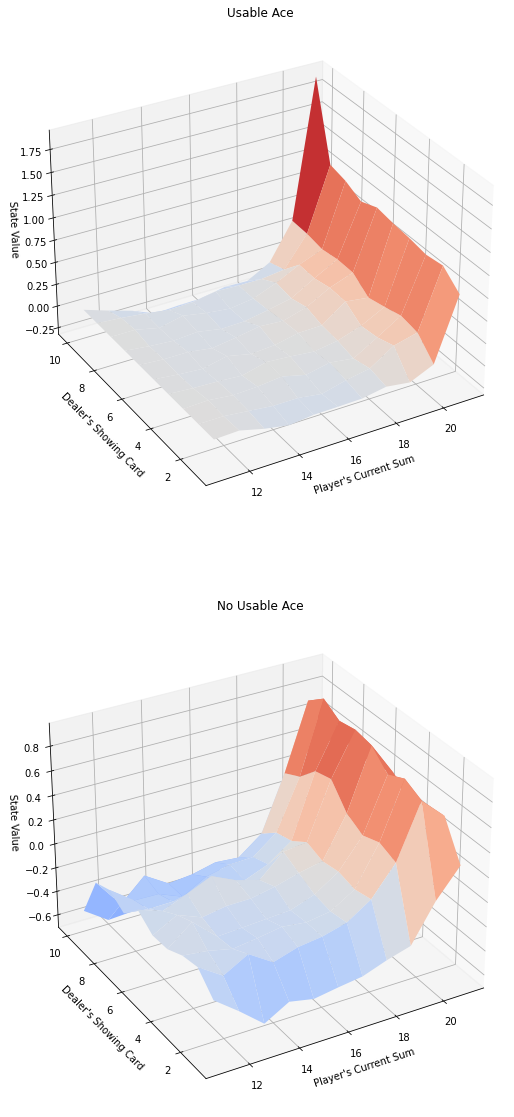

In [38]:
V = dict((state,state_value_function) for state, state_value_function in agent.V.items())
plot_blackjack_values(V)

**Temporal Difference Action Value Function**

2 Tuple(Discrete(32), Discrete(11), Discrete(2))


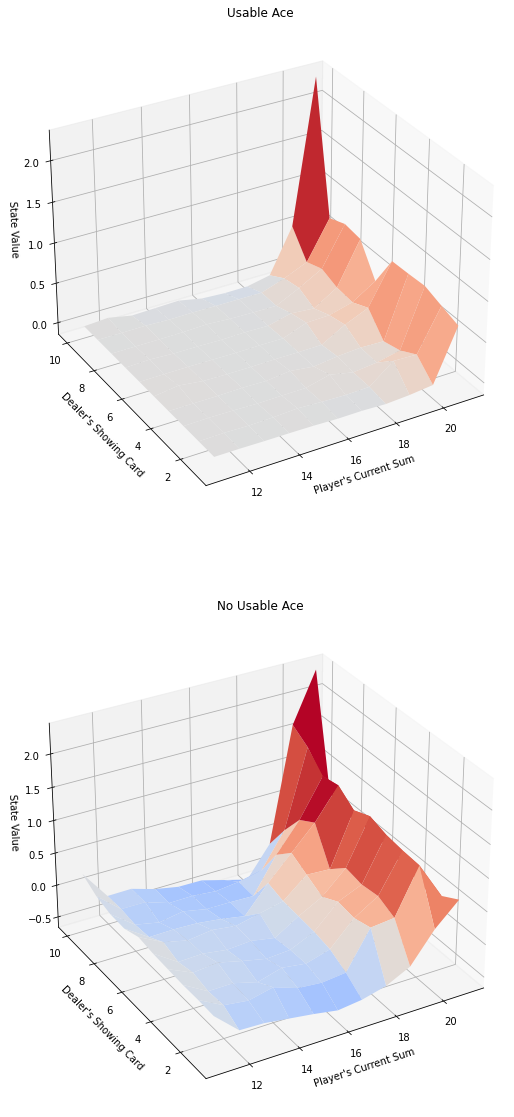

In [46]:
environment_name = "Blackjack-v1"

from dataclasses import dataclass
from collections import defaultdict, Counter

# @dataclass
# class EpisodeStep:
#     state: Any
#     action: int
#     reward: float

class BlackJackAgentTemporalDifferenceBasedOnActionValue:
    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = self.environment.action_space

        self.alpha = 0.01
        self.gamma = 0.8
        
        self.total_states = 32*11*2
        self.total_actions = 2

        self.Q = defaultdict(lambda: np.zeros(self.total_actions))

    def update_during_episode(self, epsilon = 1.0):
        current_state = self.environment.reset()
        action =  self.decide_choice(current_state, epsilon) 

        while True:
            next_state, reward, is_done, _ = self.environment.step(action)
            next_action =  self.decide_choice(next_state, epsilon) 

            sarsa = (current_state, action, reward, next_state, next_action)

            self.update_value_function_during_trajectory(*sarsa)
            if is_done:
                break
            current_state = next_state
            action = next_action

    def update_within_episode_considering_eligibility_trace(self, epsilon = 1.0, lambda_value = 0.8):
        eligibility_trace = defaultdict(lambda : np.zeros(self.total_actions))
        current_state = self.environment.reset()
        current_action = self.decide_choice(current_state, epsilon)

        while True:
            next_state, reward, is_done, _ = self.environment.step(current_action)
            next_action = self.decide_choice(next_state, epsilon)

            eligibility_trace[current_state][current_action] += 1

            old_value = self.Q[current_state][current_action]
            error_term = reward + self.gamma* self.Q[next_state][next_action] - old_value

            intermediate = self.alpha*error_term

            #self.Q[current_state][current_action] = old_value + intermediate
            # beware : below update is extremely slow
            states_to_update = self.Q.items()
            for state,_ in states_to_update:
                self.Q[state] += intermediate*eligibility_trace[state]
                eligibility_trace[state] *= self.gamma *lambda_value
                # for action in range(self.total_actions):
                #     # during the episode, reward might only be obtained at the very end
                #     # and previous states are also responsible for obtaining reward
                #     # so each state during episode will have share of estimated return based on its eligibility 
                #     self.Q[state][action] = (
                #         self.Q[state][action] + self.alpha * error_term * eligibility_trace[state][action]
                #     )

                #     # recent states will high eligibility(if visited) and eligibility decays
                #     eligibility_trace[state][action] *= lambda_value*self.gamma

            if is_done:
                break
            current_state = next_state
            current_action = next_action
        
        
    @staticmethod
    def get_probability_for_action(Q_s, epsilon, num_of_actions):
        # 1 - epsilon + (epsilon/total_actions) for action having max action-value-function
        # epsilon / total_actions for others
        policy_state = np.ones(num_of_actions) * (epsilon / num_of_actions)
        max_action = np.argmax(Q_s)
        policy_state[max_action] = 1 - epsilon + (epsilon/num_of_actions)
        return policy_state

    def decide_choice(self, state, epsilon):
        if state not in self.Q:
            return np.random.choice(self.total_actions)

        player_sum, dealer_card, usable_ace = state

        probs = self.get_probability_for_action(self.Q[state], epsilon, self.total_actions)
        return np.random.choice(np.arange(self.total_actions), p = probs)

    def update_value_function_during_trajectory(self, current_state, current_action, reward, next_state, next_action):

        estimated_return = reward + self.gamma* self.Q[next_state][next_action]

        previous_old_value = self.Q[current_state][current_action]

        self.Q[current_state][current_action] = (
            previous_old_value + self.alpha*(estimated_return - previous_old_value)
        )

launch_environment = gym.make(environment_name)
print(launch_environment.action_space.n, launch_environment.observation_space)

agent = BlackJackAgentTemporalDifferenceBasedOnActionValue(launch_environment)

epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995
lambda_value = 0.05

for i in range(20000):
    epsilon = max(epsilon* epsilon_decay, epsilon_end)
    episode = agent.update_within_episode_considering_eligibility_trace(epsilon, lambda_value)

action_values = dict((state,np.max(actions) ) for state, actions in agent.Q.items())
plot_blackjack_values(action_values)